In [ ]:
# Improved Model
# Incorporating solutions to address the above critiques:
# 1. Perform exploratory data analysis (EDA) to visually inspect data relationships.
# 2. Add interaction terms explicitly in a new linear regression model.
# 3. Perform statistical significance testing for the added metrics and interaction terms.
# 4. Test multiple non-linear models, including polynomial regression, decision trees, and random forests.
# 5. Use cross-validation for model validation.

In [1]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Load datasets
minute_sleep_data = pd.read_csv('/Users/jamesmoy/Desktop/Sleep Fitness Data/Fitabase Data 4.12.16-5.12.16//minuteSleep_merged.csv')
daily_activity_data = pd.read_csv('/Users/jamesmoy/Desktop/Sleep Fitness Data/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')
hourly_intensities_data = pd.read_csv('/Users/jamesmoy/Desktop/Sleep Fitness Data/Fitabase Data 4.12.16-5.12.16/hourlyIntensities_merged.csv')
hourly_steps_data = pd.read_csv('/Users/jamesmoy/Desktop/Sleep Fitness Data/Fitabase Data 4.12.16-5.12.16/hourlySteps_merged.csv')
# Load the sleep day dataset (already standardized and cleaned)
sleep_day_data = pd.read_csv('/Users/jamesmoy/Desktop/Sleep Fitness Data/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv')

In [4]:
# Data Cleaning
minute_sleep_data.columns = minute_sleep_data.columns.str.lower().str.replace(' ', '_')
daily_activity_data.columns = daily_activity_data.columns.str.lower().str.replace(' ', '_')
hourly_intensities_data.columns = hourly_intensities_data.columns.str.lower().str.replace(' ', '_')
hourly_steps_data.columns = hourly_steps_data.columns.str.lower().str.replace(' ', '_')
sleep_day_data.columns = sleep_day_data.columns.str.lower().str.replace(' ', '_')

In [5]:
# Convert datetime columns
sleep_day_data['sleepday'] = pd.to_datetime(sleep_day_data['sleepday'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
daily_activity_data['activitydate'] = pd.to_datetime(daily_activity_data['activitydate'], errors='coerce', format='%m/%d/%Y')


In [6]:
# Handle missing values
sleep_day_data.dropna(subset=['sleepday'], inplace=True)
daily_activity_data.dropna(subset=['activitydate'], inplace=True)


In [7]:
# Feature Engineering: Calculate sleep_quality
sleep_day_data['sleep_quality'] = sleep_day_data['totalminutesasleep'] / sleep_day_data['totaltimeinbed']


In [8]:

# Merge datasets on Id and Date
merged_data = pd.merge(daily_activity_data, sleep_day_data, left_on=['id', 'activitydate'], right_on=['id', 'sleepday'], how='inner')


In [9]:
# Select features for regression
features = ['totalsteps', 'veryactiveminutes', 'fairlyactiveminutes', 'lightlyactiveminutes', 'sedentaryminutes',
            'veryactivedistance', 'lightactivedistance', 'moderatelyactivedistance', 'calories']
X = merged_data[features]
y = merged_data['sleep_quality']

In [10]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:

# Add interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [14]:
# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [15]:
# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print("Random Forest Cross-Validation R^2 Scores:", rf_cv_scores)

Random Forest Cross-Validation R^2 Scores: [0.31181787 0.55350592 0.77258971 0.63298291 0.6095311 ]


In [16]:
# Predictions and evaluation on test data
y_pred = rf_model.predict(X_test)
print("Random Forest Test Set Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Random Forest Test Set R-squared:", r2_score(y_test, y_pred))

Random Forest Test Set Mean Squared Error: 0.0033284930004712286
Random Forest Test Set R-squared: 0.5978388494378423


In [17]:
# Feature Importance
importances = rf_model.feature_importances_
feature_names = poly.get_feature_names_out(features)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

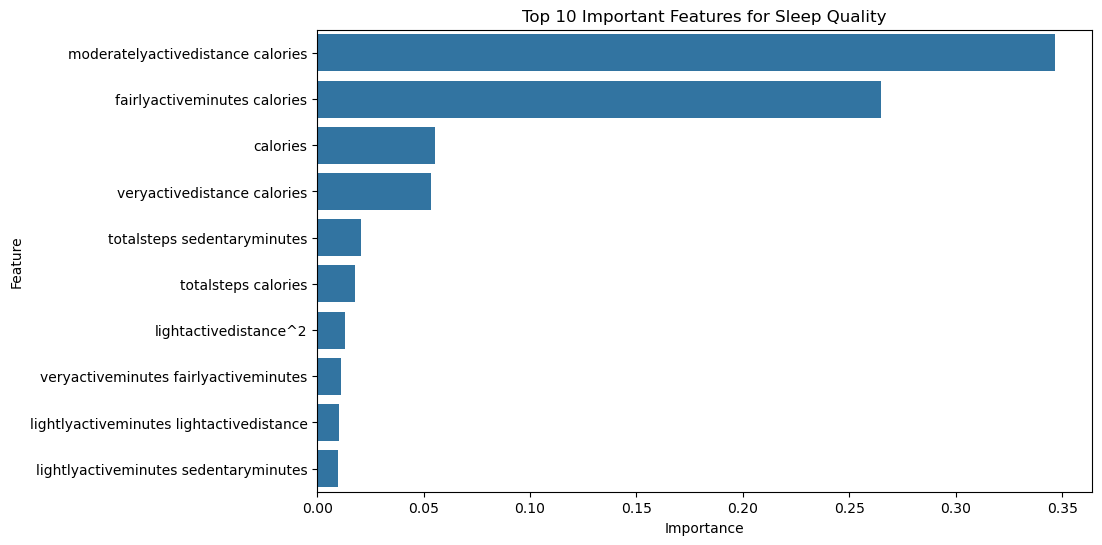

In [18]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Important Features for Sleep Quality')
plt.show()

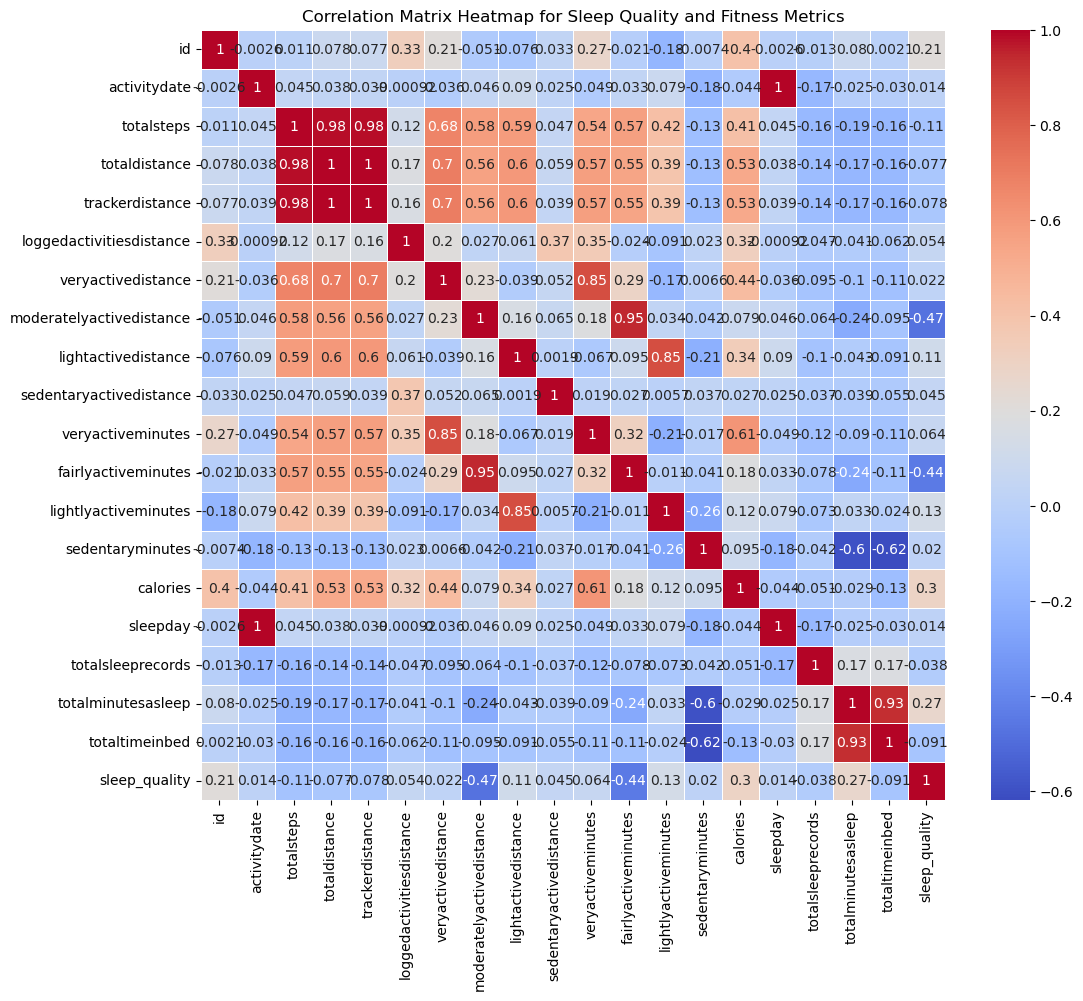


Correlation Analysis Summary:

Strong correlations for activitydate:
activitydate    1.0
sleepday        1.0
Name: activitydate, dtype: float64


Strong correlations for totalsteps:
totalsteps                  1.000000
trackerdistance             0.981652
totaldistance               0.981533
veryactivedistance          0.677084
lightactivedistance         0.586532
moderatelyactivedistance    0.581008
fairlyactiveminutes         0.569649
veryactiveminutes           0.540876
Name: totalsteps, dtype: float64


Strong correlations for totaldistance:
totaldistance               1.000000
trackerdistance             0.999561
totalsteps                  0.981533
veryactivedistance          0.702748
lightactivedistance         0.597666
veryactiveminutes           0.573987
moderatelyactivedistance    0.561138
fairlyactiveminutes         0.550300
calories                    0.527728
Name: totaldistance, dtype: float64


Strong correlations for trackerdistance:
trackerdistance             1.00000

In [19]:
# Heatmap Visualization of Correlations
correlation_matrix = merged_data.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap for Sleep Quality and Fitness Metrics')
plt.show()

# Interpretation of Correlation Matrix
print("\nCorrelation Analysis Summary:\n")
for column in correlation_matrix.columns:
    strong_correlations = correlation_matrix[column][(correlation_matrix[column] > 0.5) | (correlation_matrix[column] < -0.5)].sort_values(ascending=False)
    if len(strong_correlations) > 1:  # Exclude self-correlation
        print(f"Strong correlations for {column}:")
        print(strong_correlations)
        print("\n")

In [20]:
# Export the feature importance dataset to a CSV for Tableau
importance_file = "feature_importance_for_tableau.csv"
importance_df.to_csv(importance_file, index=False)
print(f"Feature importance dataset exported successfully to {importance_file}")

# Export the merged dataset to a CSV for Tableau
merged_data_file = "merged_data_for_tableau.csv"
merged_data.to_csv(merged_data_file, index=False)
print(f"Merged dataset exported successfully to {merged_data_file}")


Feature importance dataset exported successfully to feature_importance_for_tableau.csv
Merged dataset exported successfully to merged_data_for_tableau.csv
